In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys, PIL.Image, matplotlib.pyplot as plt, itertools, math, random, collections, torch, inspect
from functools import wraps, partial
from dataclasses import dataclass, field
import inspect
import random
from copy import copy, deepcopy
from typing import Dict, Any, AnyStr, List, Sequence, TypeVar, Tuple, Optional, Union, Iterable, cast, Collection, Callable
from numpy import cos, sin, tan, tanh, log, exp
from pdb import set_trace
import torch.nn.functional as F
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import scipy
import scipy.stats, scipy.special
import tqdm

In [3]:
def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def get_arg_names(func):
    return list(inspect.signature(func).parameters)

def get_dynamic_var_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()}

def bind_args(func, v):
    arg_names = get_arg_names(func)
    bound_args = { arg_names[i]: vi for i, vi in enumerate(v)}
    return bound_args
        

def resolve_fun_annotations(func, kwargs):
    params = copy(func.__annotations__)
    resolved = {}
    for k, v in kwargs.items():
        if k in params and not isinstance(v, Dynamic):
            rand_func = params[k]
            if isinstance(v, Dict): resolved[k] = rand_func(**v)
            elif isinstance(v, Iterable):
                arg_names = get_arg_names(rand_func)
                bound_args = bind_args(rand_func, v)
                resolved[k] = rand_func(**bound_args)
            else: 
                # gross hack
                if rand_func == Bool and k == 'p':
                    resolved[k] = rand_func(v)
                else:
                    resolved[k] = v
        else: resolved[k] = v
    return resolved


def dynamic_resolve(a):
    if isinstance(a, Dynamic): return a.resolve()
    else: return a

def dynamic_release(a):
    if isinstance(a, Dynamic): return a.release()
    elif isinstance(a, list):
        for ai in a: dynamic_release(ai)
    elif isinstance(a, dict):
        for vi in a.values(): dynamic_release(vi)
            
class Dynamic(object):
    def __init__(self, func=None, args=None, kwargs=None):
        self.func = func       
        self.args = args
        self.kwargs = resolve_fun_annotations(self.func, kwargs) if kwargs else {}
        self.def_args = get_default_args(self.func) 
        self.init_state()
        
    def init_state(self):
        self.value_ = None
        self.bound = False
        self.bound_args = {}
        self.bound_kwargs = {}

    def clone(self, **kwargs):
        copy_kwargs = {k:copy(v) for k,v in self.kwargs.items()}
        copy_args = copy(self.args)
        kwargs = {**copy_kwargs, **kwargs}
        dtype = type(self)
        new_dynamic = dtype(func=self.func, args=copy_args, kwargs=kwargs)
        new_dynamic.__dict__.update({k:v for k,v in self.__dict__.items()
                                     if k not in new_dynamic.__dict__})
        return new_dynamic
    
    def __copy__(self):
        return self.clone()
    
    def bind(self, **kwargs):
        if not self.bound:
            kwargs = resolve_fun_annotations(self.func, kwargs) 
            self.bound_args = bind_args(self.func, self.args) if self.args else {}
            kwargs = {**self.def_args, **self.kwargs, **self.bound_args, **kwargs}
            kwargs = {k:dynamic_resolve(v) for k,v in kwargs.items()}
            self.bound = True
            self.bound_kwargs = kwargs
            self.value = None
        elif kwargs:
            kwargs = resolve_fun_annotations(self.func, kwargs)
            kwargs = {k:dynamic_resolve(v) for k,v in kwargs.items()}
            self.bound_kwargs = {**self.bound_kwargs, **self.bound_args, **kwargs}
            self.value = None
                   
    def release(self):
        dynamic_release(self.kwargs)
        dynamic_release(self.bound_args)
        dynamic_release(self.def_args)
        dynamic_release(self.func)
        self.init_state()
    
    def __repr__(self):
        return f'{self.func.__name__}:{self.kwargs}:{self.value_}'
    
                
class DynamicVar(Dynamic):      
    def __init__(self, func=None, args=None, kwargs=None):
        super().__init__(func=func, args=args, kwargs=kwargs)
        
    def resolve(self):
        self.bind()
        if self.value_ is None:
            self.value_ = self.func(**self.bound_kwargs)
        return self.value_


class DynamicFunc(Dynamic):      
    def __init__(self, func=None, args=None, kwargs=None):
        assert(args is None)
        super().__init__(func=func, args=args, kwargs=kwargs)
        
    def resolve(self):
        self.bind()
        return self
    
    def __call__(self, *args, **kwargs):
        self.bind(**kwargs)
        return self.func(*args, **self.bound_kwargs)  


def dynamic_var(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return DynamicVar(func=func, args=args, kwargs=kwargs) 
    return wrapper

def dynamic_func(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        f = DynamicFunc(func=func, kwargs=kwargs)
        if args:return f(*args)
        else: return f
    return wrapper

def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

@dynamic_var
def Uniform(low, high, size=None):
    value = uniform(low, high, size=size)
    return value

@dynamic_var
def LogUniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    value = exp(res) if size is None else res.exp_()
    return value

@dynamic_var
def Bool(p, size=None):
    return uniform(0, 1, size=size)<p

@dynamic_var
def Const(c):
    return c

@dynamic_var
def Choice(choices):
    return random.choice(choices)

In [4]:
@dynamic_func
def maybe(*args,f=None, p:Bool=False, **kwargs):
    #print('maybe',p,f)
    if p: return f(*args, **kwargs)
    else: return args[0]
    

@dynamic_func
def img_wrap(img, f=None, wrap=None):
    return getattr(img, wrap)(f)
    
# sticks a p variable on a function
def Transform(mfunc, order=0, wrap=None):
    dmfunc = dynamic_func(mfunc)
    tfm_type = wrap if wrap else 'unknown'
    @wraps(dmfunc)
    def make_trans(*args,p:Bool=True, **kwargs):
        m = dmfunc(**kwargs)
        if wrap: m = img_wrap(f=m, wrap=wrap)
        res = maybe(*args, f=m, p=p)
        res.order = order
        res.tfm_type = tfm_type
        return res
    make_trans.order = order
    make_trans.tfm_type = tfm_type
    return make_trans

TfmLighting = partial(Transform, order=9, wrap='lighting')
TfmAffine = partial(Transform, order=5, wrap='affine')
TfmPixel = partial(Transform, order=10, wrap='pixel')
TfmCoord = partial(Transform, order=4, wrap='coord')
TfmPad = partial(Transform, order=-10, wrap='pixel')

def is_lighting(tfm): tfm.tfm_type == 'lighting'
def is_affine(tfm): tfm.tfm_type == 'affine'

In [5]:
@Transform
def mm(x,by:Uniform=2,mode:Bool=True):
    print('mode', mode)
    return x * by

m1 = mm(by=(-2,2),p=0.5)
m1.foobar = 'fred'
m2 = partial(m1, mode=False) 

for i in range(10):
    #if (m1(2) != m2(2,mode=False)):
    print(m1(2), m2(2,mode=False))
    m1.release()

mode True
mode False
-2.397722612539255 -2.397722612539255
mode True
mode False
-2.725748675841639 -2.725748675841639
mode True
mode False
-2.6754547762703274 -2.6754547762703274
mode True
mode False
-2.455166441311815 -2.455166441311815
2 2
2 2
mode True
mode False
-0.05185931805923438 -0.05185931805923438
mode True
mode False
-2.8933943420043295 -2.8933943420043295
2 2
mode True
mode False
-1.1823720728617708 -1.1823720728617708


In [6]:
#%debug

In [7]:
def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

def logit(x):  return -(1/x-1).log()
def logit_(x): return (x.reciprocal_().sub_(1)).log_().neg_()

@TfmLighting
def brightness(x, change:Uniform=1.0): return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:LogUniform=1.0): return x.mul_(scale)

@TfmAffine
def rotate(degrees:Uniform):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

def get_zoom_mat(sw, sh, c, r):
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

@TfmAffine
def zoom(scale:Uniform=1.0, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return get_zoom_mat(1/scale, 1/scale, col_c, row_c)

@TfmAffine
def squish(scale:Uniform=1.0, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    if scale <= 1: 
        col_c = (1-scale) * (2*col_pct - 1)
        return get_zoom_mat(scale, 1, col_c, 0.)
    else:          
        row_c = (1-1/scale) * (2*row_pct - 1)
        return get_zoom_mat(1, 1/scale, 0., row_c)
    
@TfmCoord
def jitter(c, size, magnitude:Uniform):
    return c.add_((torch.rand_like(c)-0.5)*magnitude*2)

@TfmPixel
def flip_lr(x): 
    print('do flip')
    return x.flip(2)

@TfmPad
def pad(x, padding, mode='reflect'):
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@TfmPixel
def crop(x, size, row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()


def compute_zs_mat(sz, scale, squish, invert, row_pct, col_pct):
    orig_ratio = math.sqrt(sz[2]/sz[1])
    for s,r,i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r <= 1: #Test if we are completely inside the picture
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)
        
    #Fallback, hack to emulate a center crop without cropping anything yet.
    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

@TfmCoord
def zoom_squish(c, size, scale:Uniform=1.0, squish:Uniform=1.0, invert:Bool=False, 
                row_pct:Uniform=0.5, col_pct:Uniform=0.5):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = compute_zs_mat(size, scale, squish, invert, row_pct, col_pct)
    return affine_mult(c, FloatTensor(m))

In [8]:
def pil2tensor(image, as_mask=False):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    arr = arr.permute(2,0,1).float()
    return arr if as_mask else arr.div_(255)

def open_image(fn, as_mask=False):
    x = PIL.Image.open(fn)
    if not as_mask: x = x.convert('RGB')
    return pil2tensor(x, as_mask=as_mask)

def image2np(image):
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res




def show_xy_image(xim, yim, ax=None, figsize=(3,3), alpha=0.5, hide_axis=True):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(xim))
    ax.imshow(image2np(yim), alpha=alpha)
    if hide_axis: ax.axis('off')


def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows,figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_xy_image(x[i], y[i], ax)
        #show_image(x[i], ax)
        #ax.set_title(classes[y[i]])
    plt.tight_layout()
    
    
class Image():
    def __init__(self, px):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self): return self._px.shape
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.px.shape})'

    def refresh(self):
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            print('sample', self.sample_kwargs)
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self):
        self.refresh()
        return self._px
    @px.setter
    def px(self,v): self._px=v

    @property
    def flow(self):
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    @flow.setter
    def flow(self,v): self._flow=v

    def lighting(self, func, *args, **kwargs):
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func, *args, **kwargs):
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func, *args, **kwargs):
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func, *args, **kwargs):
        m = func(*args, **kwargs)
        self.affine_mat = self.affine_mat @ self._px.new(m)
        return self

    def set_sample(self, **kwargs):
        self.sample_kwargs = kwargs
        return self

    def resize(self, size):
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self):
        if self._affine_mat is None: self._affine_mat = self._px.new(torch.eye(3))
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v): self._affine_mat=v

    @property
    def logit_px(self):
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v): self._logit_px=v
    
    def show(self, ax=None, **kwargs): show_image(self.px, ax=ax, **kwargs)
    def clone(self): return self.__class__(self.px.clone())
    
    
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if padding_mode=='reflect': padding_mode='reflection'
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(size):
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else torch.Tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else torch.Tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

In [9]:
PATH = Path('data/carvana')
PATH_PNG = PATH/'train_masks_png'
PATH_X = PATH/'train-128'
PATH_Y = PATH/'train_masks-128'

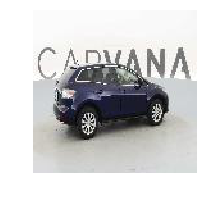

In [10]:
img_f = next(PATH_X.iterdir())
x = open_image(img_f)
show_image(x)

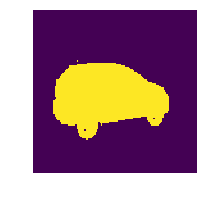

In [11]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}_mask.png'

img_y_f = get_y_fn(img_f)
y = open_image(img_y_f, as_mask=True)
show_image(y)

In [12]:
tfms = [
    flip_lr(p=0.5),
    rotate(degrees=(-20,20.), p=0.75),
    zoom(scale=(0.5,2), p=0.75),
    contrast(scale=(0.6,1.4)),
    brightness(change=(0.3,0.7))
]

In [13]:
tfms

[maybe:{'f': img_wrap:{'f': flip_lr:{}:None, 'wrap': 'pixel'}:None, 'p': Bool:{}:None}:None,
 maybe:{'f': img_wrap:{'f': rotate:{'degrees': Uniform:{'low': -20, 'high': 20.0}:None}:None, 'wrap': 'affine'}:None, 'p': Bool:{}:None}:None,
 maybe:{'f': img_wrap:{'f': zoom:{'scale': Uniform:{'low': 0.5, 'high': 2}:None}:None, 'wrap': 'affine'}:None, 'p': Bool:{}:None}:None,
 maybe:{'f': img_wrap:{'f': contrast:{'scale': LogUniform:{'low': 0.6, 'high': 1.4}:None}:None, 'wrap': 'lighting'}:None, 'p': Bool:{}:None}:None,
 maybe:{'f': img_wrap:{'f': brightness:{'change': Uniform:{'low': 0.3, 'high': 0.7}:None}:None, 'wrap': 'lighting'}:None, 'p': Bool:{}:None}:None]

In [14]:
def resolve_tfms(tfms): 
    for f in listify(tfms):
        f.release()
        
def is_listy(x)->bool: return isinstance(x, (tuple,list))

def apply_tfms(tfms, x, do_resolve=True, aspect=None, size=None,
               padding_mode='reflect', **kwargs):
    if not tfms: return x
    tfms = sorted(listify(tfms), key=lambda o: o.order)
    if do_resolve: resolve_tfms(tfms)
    x = Image(x.clone())
    x.set_sample(padding_mode=padding_mode, **kwargs)
    x.aspect = aspect
    x.size = size
    
    for tfm in tfms:
        x = tfm(x)
            
    return x.px

In [15]:
tfms[0].tfm_type

'pixel'

In [16]:
copy(tfms[0]).tfm_type

'pixel'

sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect'}
do flip


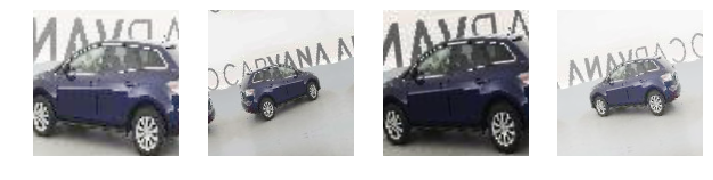

In [17]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms,x), ax)

In [18]:
@dataclass
class MatchedFilesDataset(Dataset):
    x_fns:List[Path]; y_fns:List[Path]
    def __post_init__(self): assert len(self.x_fns)==len(self.y_fns)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), open_image(self.y_fns[i])

In [19]:
x_fns = [o for o in PATH_X.iterdir() if o.is_file()]
y_fns = [get_y_fn(o) for o in x_fns]
train_ds = MatchedFilesDataset(x_fns, y_fns)
train_ds

MatchedFilesDataset of len 5088

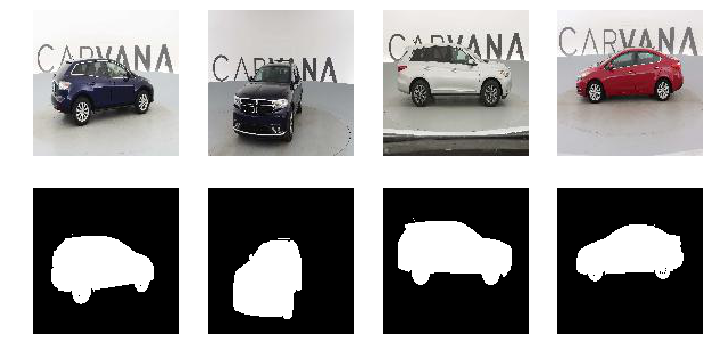

In [20]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    imgx,imgy = train_ds[i]
    show_image(imgx, axes[0][i])
    show_image(imgy, axes[1][i])

sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip
sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip


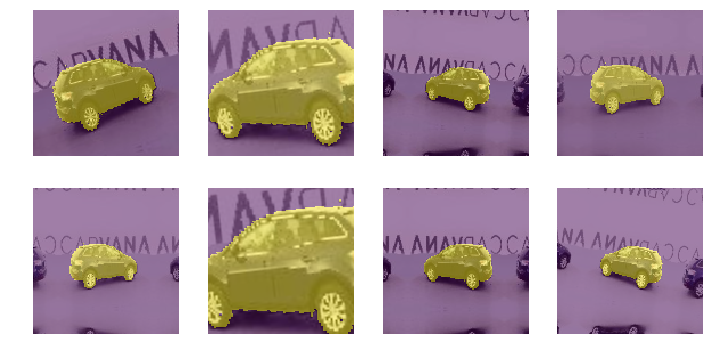

In [21]:
def make_segmentation_tfms(tfms):
    seg_tfms = []
    for tfm in tfms:
        if tfm.tfm_type != 'lighting':
            #overrides = {'mode': 'nearest'} if tfm.tfm_type == 'affine' else {}
            #overrides = {}
            seg_tfms.append(tfm)
    return seg_tfms

x_tfms = tfms
y_tfms = make_segmentation_tfms(x_tfms)

default_mean,default_std = map(tensor, ([0.5]*3, [0.5]*3))
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(8):
    imgx,imgy = apply_tfms(x_tfms, x, do_resolve=True), apply_tfms(y_tfms, y, do_resolve=False, mode='nearest')
    #imgx,imgy = x, y
    show_xy_image(imgx, imgy, axes[i//4][i%4])
    #show_image(imgx, axes[0][i])
    #show_image(imgy, axes[1][i])

In [22]:
len(x_tfms),len(y_tfms)

(5, 3)

x(0):  maybe:{'f': img_wrap:{'f': flip_lr:{}:None, 'wrap': 'pixel'}:None, 'p': Bool:{}:False}:None
x(1):  maybe:{'f': img_wrap:{'f': rotate:{'degrees': Uniform:{'low': -20, 'high': 20.0}:-6.892897266993341}:None, 'wrap': 'affine'}:None, 'p': Bool:{}:False}:None
x(2):  maybe:{'f': img_wrap:{'f': zoom:{'scale': Uniform:{'low': 0.5, 'high': 2}:1.8023274252490005}:None, 'wrap': 'affine'}:None, 'p': Bool:{}:False}:None
x(3):  maybe:{'f': img_wrap:{'f': contrast:{'scale': LogUniform:{'low': 0.6, 'high': 1.4}:0.9112748958290333}:None, 'wrap': 'lighting'}:None, 'p': Bool:{}:True}:None
x(4):  maybe:{'f': img_wrap:{'f': brightness:{'change': Uniform:{'low': 0.3, 'high': 0.7}:0.6100749124441757}:None, 'wrap': 'lighting'}:None, 'p': Bool:{}:True}:None
***************************
y(0):  maybe:{'f': img_wrap:{'f': flip_lr:{}:None, 'wrap': 'pixel'}:None, 'p': Bool:{}:False}:None
y(1):  maybe:{'f': img_wrap:{'f': rotate:{'degrees': Uniform:{'low': -20, 'high': 20.0}:-6.892897266993341}:None, 'wrap': '

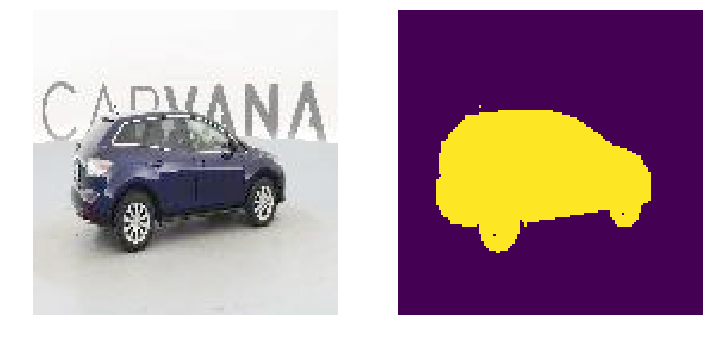

In [23]:
resolve_tfms(x_tfms)
imgx,imgy = apply_tfms(x_tfms, x, do_resolve=True), apply_tfms(y_tfms, y, do_resolve=False, mode='nearest')

_,axes = plt.subplots(1,2, figsize=(12,6))
show_image(imgx, axes[0])
show_image(imgy, axes[1])
for i in range(len(x_tfms)):
    print(f'x({i}): ',x_tfms[i])
print('***************************')
for i in range(len(y_tfms)):
    print(f'y({i}): ',y_tfms[i])

In [24]:
class DatasetTfm(Dataset):
    def __init__(self, ds:Dataset, x_tfms:Collection[Callable]=None, y_tfms:Collection[Callable]=None):
        self.ds,self.x_tfms,self.y_tfms = ds,x_tfms,y_tfms
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.x_tfms is not None: x = apply_tfms(self.x_tfms, x, do_resolve=True)
        if self.y_tfms is not None: y = apply_tfms(self.y_tfms, y, do_resolve=False, mode='nearest')
        return x,y

In [25]:
train_tds = DatasetTfm(train_ds, x_tfms=x_tfms, y_tfms=y_tfms)

sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
sample {'padding_mode': 'reflect'}
do flip
sample {'padding_mode': 'reflect', 'mode': 'nearest'}
do flip
sample {'padding_mode': 'reflect'}
sample {'padding_mode': 'reflect', 'mode': 'nearest'}


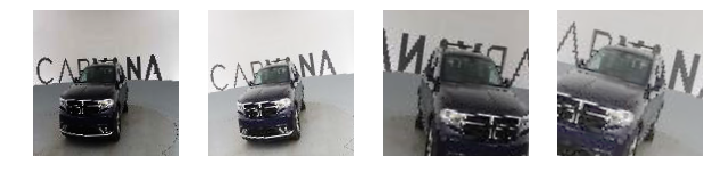

In [26]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(train_tds[1][0], ax)

In [27]:
default_device = torch.device('cuda')
def to_device(device, b): return [o.to(device) for o in b]

def normalize(x, mean,std):   return (x-mean[...,None,None]) / std[...,None,None]
def denormalize(x, mean,std): return x*std[...,None,None] + mean[...,None,None]

def normalize_batch(b, mean, std, do_y=False):
    x,y = b
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean, std, do_y=False, device=None):
    if device is None: device=default_device
    return (partial(normalize_batch, mean=mean.to(device),std=std.to(device), do_y=do_y),
            partial(denormalize,     mean=mean,           std=std))

@dataclass
class DeviceDataLoader():
    dl: DataLoader
    device: torch.device
    progress_func:Callable=None
    tfms: List[Callable]=None

    def __len__(self): return len(self.dl)

    def proc_batch(self,b):
        b = to_device(self.device,b)
        return b if self.tfms is None else self.tfms(b)
    
    def __iter__(self):
        self.gen = map(self.proc_batch, self.dl)
        if self.progress_func is not None:
            self.gen = self.progress_func(self.gen, total=len(self.dl), leave=False)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device=default_device, progress_func=tqdm, tfms=tfms, **kwargs):
        return cls(DataLoader(*args, **kwargs), device=device, progress_func=progress_func, tfms=tfms)

In [28]:
default_mean,default_std = map(tensor, ([0.5]*3, [1.0]*3))
default_norm,default_denorm = normalize_funcs(default_mean,default_std, do_y=True)

In [29]:
bs = 64
train_dl = DeviceDataLoader.create(train_ds, bs, tfms=default_norm, shuffle=True, progress_func=None)

In [30]:
x,y = next(iter(train_dl))
x = x.cpu()
print(x.min(),x.max(),x.mean(),x.std())
x = default_denorm(x)
y = default_denorm(y)
show_images(x,y,6, figsize=(9,10))

tensor(-0.5000) tensor(0.5000) tensor(0.2009) tensor(0.2506)


RuntimeError: TensorIterator expected type torch.cuda.FloatTensor but got torch.FloatTensor[3, 1, 1]